In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from pathlib import Path
import glob

class TensorBoardPlotter:
    def __init__(self, figsize=(12, 8)):
        self.figsize = figsize
        self.colors = {
            'ddpg': "#00a429", 'd4pg': "#00a2ff", 'mpo': "#7d00c1", 'sac': "#ff8b0e"
        }
        
    def exponential_smoothing(self, data, alpha=0.6):
        """Apply exponential smoothing similar to TensorBoard"""
        if len(data) == 0:
            return data
        
        smoothed = np.zeros_like(data)
        smoothed[0] = data[0]
        
        for i in range(1, len(data)):
            smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i-1]
        
        return smoothed
    
    def load_tensorboard_csv(self, csv_path):
        """Load TensorBoard CSV export"""
        df = pd.read_csv(csv_path)
        
        # Common TensorBoard CSV column names
        step_col = None
        value_col = None
        
        for col in df.columns:
            if 'step' in col.lower():
                step_col = col
            elif 'value' in col.lower():
                value_col = col
        
        if step_col is None or value_col is None:
            print(f"Available columns: {df.columns.tolist()}")
            print("Please specify step_col and value_col manually")
            return None
            
        return df[[step_col, value_col]].rename(columns={step_col: 'Step', value_col: 'Value'})
    
    def plot_multiple_runs(self, csv_files_or_data, models, labels=None, 
                          smoothing=0.6, show_original=False, 
                          title="Training Metrics", xlabel="Step", ylabel="Value",
                          figsize=None, save_path=None, dpi=300):
        """
        Plot multiple runs with TensorBoard-style formatting
        
        Parameters:
        - csv_files_or_data: list of CSV file paths or DataFrames
        - labels: list of labels for each run
        - smoothing: smoothing factor (0=no smoothing, 0.99=heavy smoothing)
        - show_original: whether to show faded original data
        - title, xlabel, ylabel: plot labels
        - figsize: figure size tuple
        - save_path: path to save the plot
        - dpi: resolution for saved plot
        """
        
        if figsize:
            self.figsize = figsize
            
        fig, ax = plt.subplots(figsize=self.figsize)
        
        # Process each dataset
        for i, data in enumerate(csv_files_or_data):
            if isinstance(data, str):  # It's a file path
                df = self.load_tensorboard_csv(data)
                if df is None:
                    continue
            else:  # It's already a DataFrame
                df = data
                
            steps = df['Step'].values
            values = df['Value'].values
            
            # Remove any NaN values
            mask = ~np.isnan(values)
            steps = steps[mask]
            values = values[mask]
            
            if len(steps) == 0:
                continue
                
            color = self.colors[models[i]] if i < len(models) and models[i] in self.colors else self.colors['ddpg']
            label = labels[i] if labels and i < len(labels) else f'Run {i+1}'
            
            # Plot original data (faded) if requested
            if show_original:
                ax.plot(steps, values, color=color, alpha=0.3, linewidth=0.5)
            
            # Apply smoothing
            if smoothing > 0:
                smoothed_values = self.exponential_smoothing(values, alpha=smoothing)
                ax.plot(steps, smoothed_values, color=color, linewidth=2, label=label)
            else:
                ax.plot(steps, values, color=color, linewidth=2, label=label)
        
        # Styling to match TensorBoard
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # Grid styling
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#fafafa')
        
        # Legend
        """legend = ax.legend(frameon=True, fancybox=True, shadow=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.9)
        legend.set_bbox_to_anchor((0.995, 0.06))"""
        # Place the legend outside the plot, in the bottom and in line, centered
        legend = ax.legend(frameon=True, fancybox=True, shadow=True, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
        
        # Set x ticks to be in e6 instead of e7
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
        ax.tick_params(axis='x', labelsize=10)
        
        # Tight layout
        plt.tight_layout()
        
        # Save if requested
        if save_path:
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"Plot saved to: {save_path}")
        
        plt.show()
        return fig, ax

# Example usage functions
def quick_plot_single(csv_path, smoothing=0.6, title=None, model="ddpg", labels=None):
    """Quick plot for a single CSV file"""
    plotter = TensorBoardPlotter()
    
    if title is None:
        title = Path(csv_path).stem
    
    if labels is None:
        labels = [title]
    if type(labels) is not list:
        labels = [labels]
        
    plotter.plot_multiple_runs(
        [csv_path], 
        models=[model],
        labels=labels,
        smoothing=smoothing,
        show_original=True,
        title=title
    )

def quick_plot_multiple(csv_paths, models=[], labels=None, smoothing=0.6, title="Training Comparison"):
    """Quick plot for multiple CSV files"""
    plotter = TensorBoardPlotter()
    
    if labels is None:
        labels = [i.upper() for i in models]
    
    plotter.plot_multiple_runs(
        csv_paths,
        models=models,
        labels=labels,
        smoothing=smoothing,
        show_original=True,
        title=title,
        save_path="tensorboard_comparison.png"
    )

# Auto-detect and plot all CSV files in current directory
def plot_all_csvs_in_directory(directory=".", smoothing=0.6):
    """Automatically find and plot all CSV files in a directory"""
    csv_files = glob.glob(f"{directory}/*.csv")
    
    if not csv_files:
        print("No CSV files found in the directory")
        return
    
    print(f"Found {len(csv_files)} CSV files:")
    for f in csv_files:
        print(f"  - {f}")
    
    quick_plot_multiple(csv_files, smoothing=smoothing)

# Interactive plotting function
def interactive_plot():
    """Interactive function to customize your plot"""
    print("=== TensorBoard-Style Plot Creator ===")
    
    # Get CSV files
    csv_input = input("Enter CSV file paths (comma-separated): ").strip()
    csv_files = [f.strip() for f in csv_input.split(',')]
    
    # Get labels
    labels_input = input("Enter labels (comma-separated, or press Enter for auto): ").strip()
    labels = [l.strip() for l in labels_input.split(',')] if labels_input else None
    
    # Get smoothing
    smoothing_input = input("Enter smoothing factor (0-0.99, default 0.6): ").strip()
    smoothing = float(smoothing_input) if smoothing_input else 0.6
    
    # Get title
    title = input("Enter plot title (default: 'Training Metrics'): ").strip()
    title = title if title else "Training Metrics"
    
    # Show original data?
    show_orig = input("Show original (unsmoothed) data? (y/n, default y): ").strip().lower()
    show_original = show_orig != 'n'
    
    # Create plot
    plotter = TensorBoardPlotter()
    plotter.plot_multiple_runs(
        csv_files,
        labels=labels,
        smoothing=smoothing,
        show_original=show_original,
        title=title,
        save_path=f"{title.replace(' ', '_').lower()}.png"
    )

# Example usage:

# Example 1: Single file
# quick_plot_single("data/ddpg_critic_loss_explode.csv", smoothing=0.6, title="DDPG Critic Loss", model="ddpg", labels="DDPG")

# Example 2: Multiple files
# quick_plot_multiple(["data/ddpg_critic_loss_explode.csv", "data/sac_critic_loss_explode.csv"],
#                     models=["ddpg", "sac"], 
#                     smoothing=0.6,
#                     title="Critic Comparison")

# Example 3: Auto-detect all CSVs
# plot_all_csvs_in_directory()

# Example 4: Interactive mode
# interactive_plot()

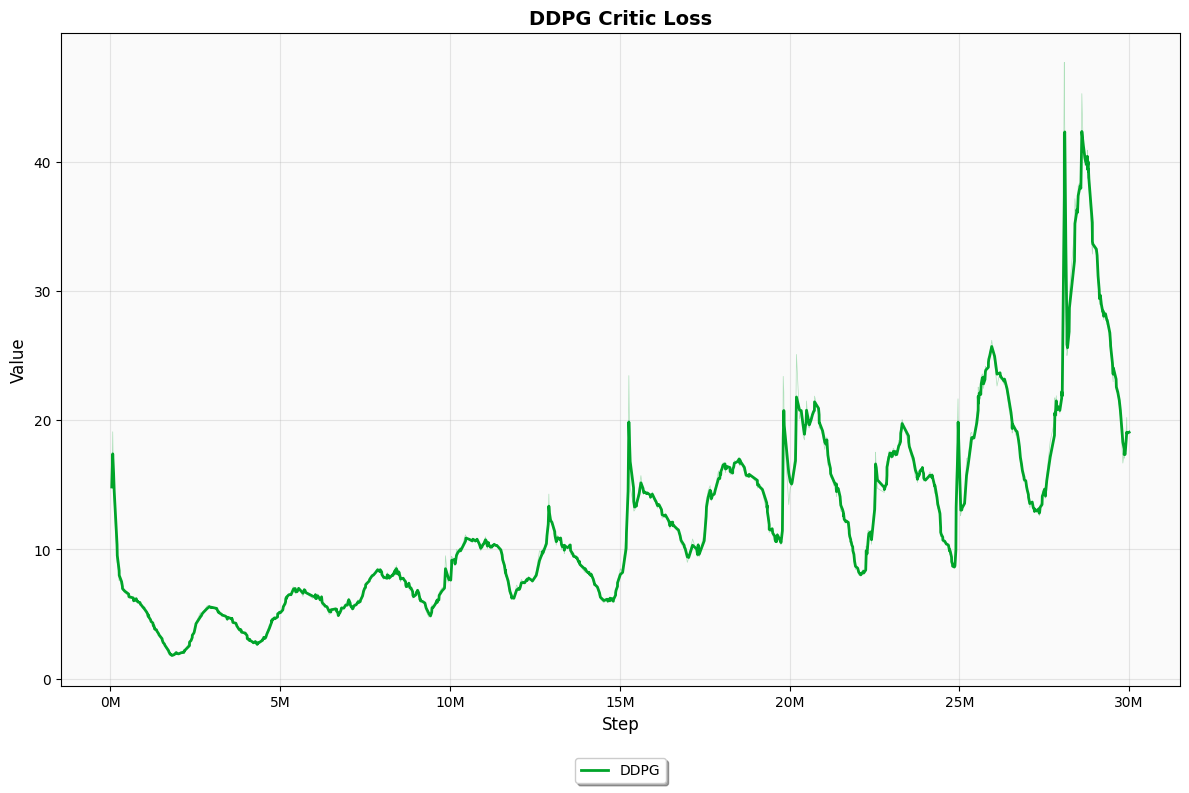

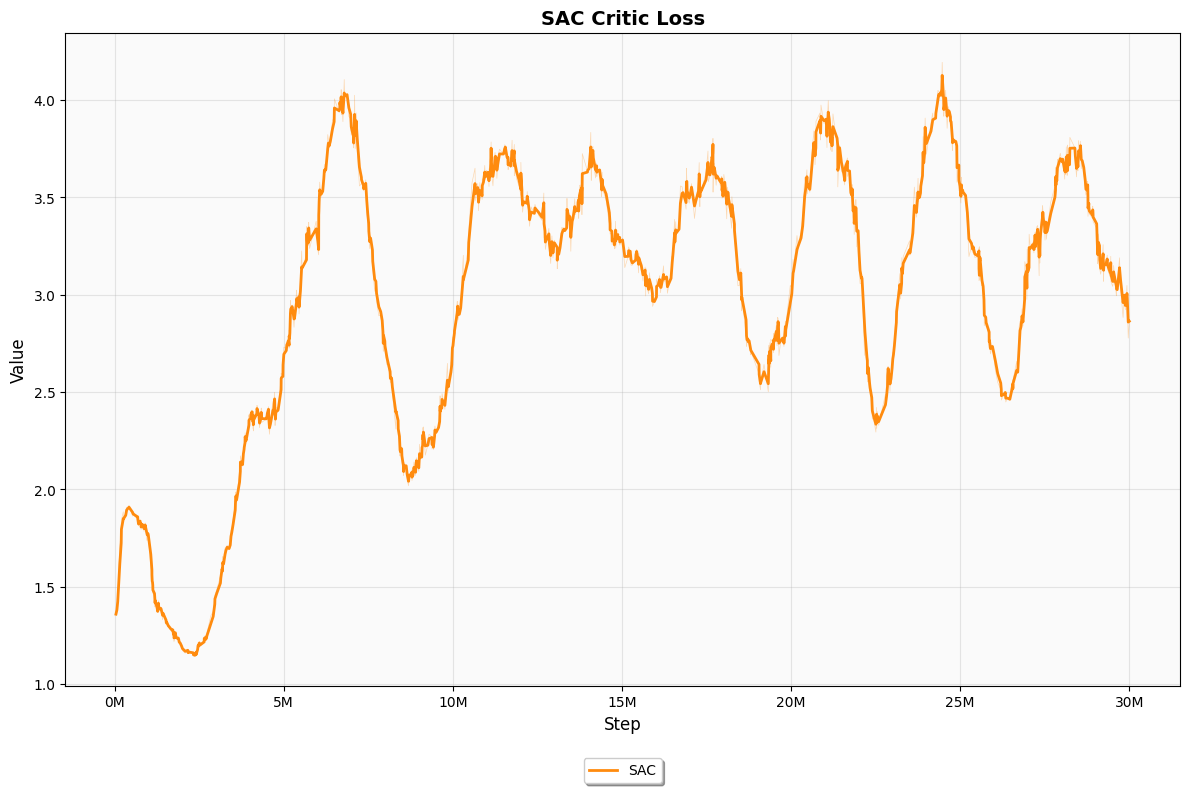

In [3]:
quick_plot_single("data/ddpg_critic_loss_explode.csv", smoothing=0.6, title="DDPG Critic Loss", model="ddpg", labels="DDPG")
quick_plot_single("data/sac_critic_loss_explode.csv", smoothing=0.6, title="SAC Critic Loss", model="sac", labels="SAC")

Plot saved to: tensorboard_comparison.png


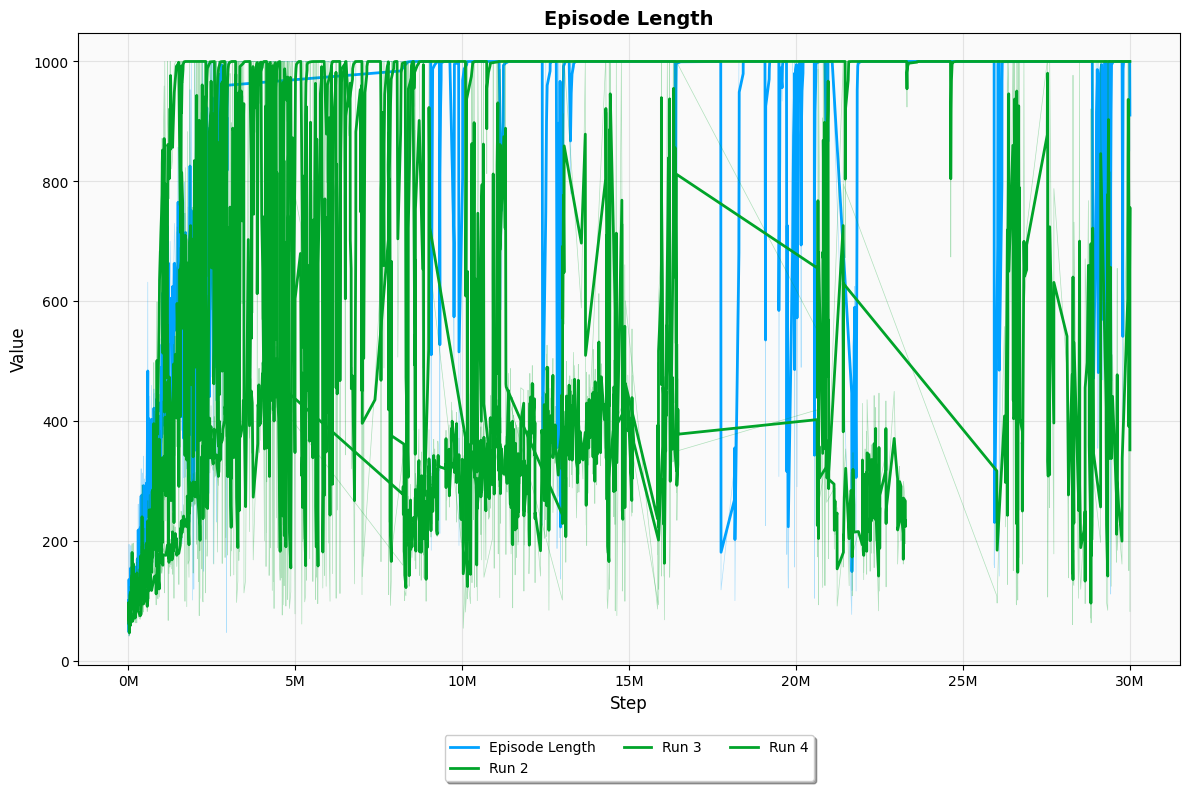

Plot saved to: tensorboard_comparison.png


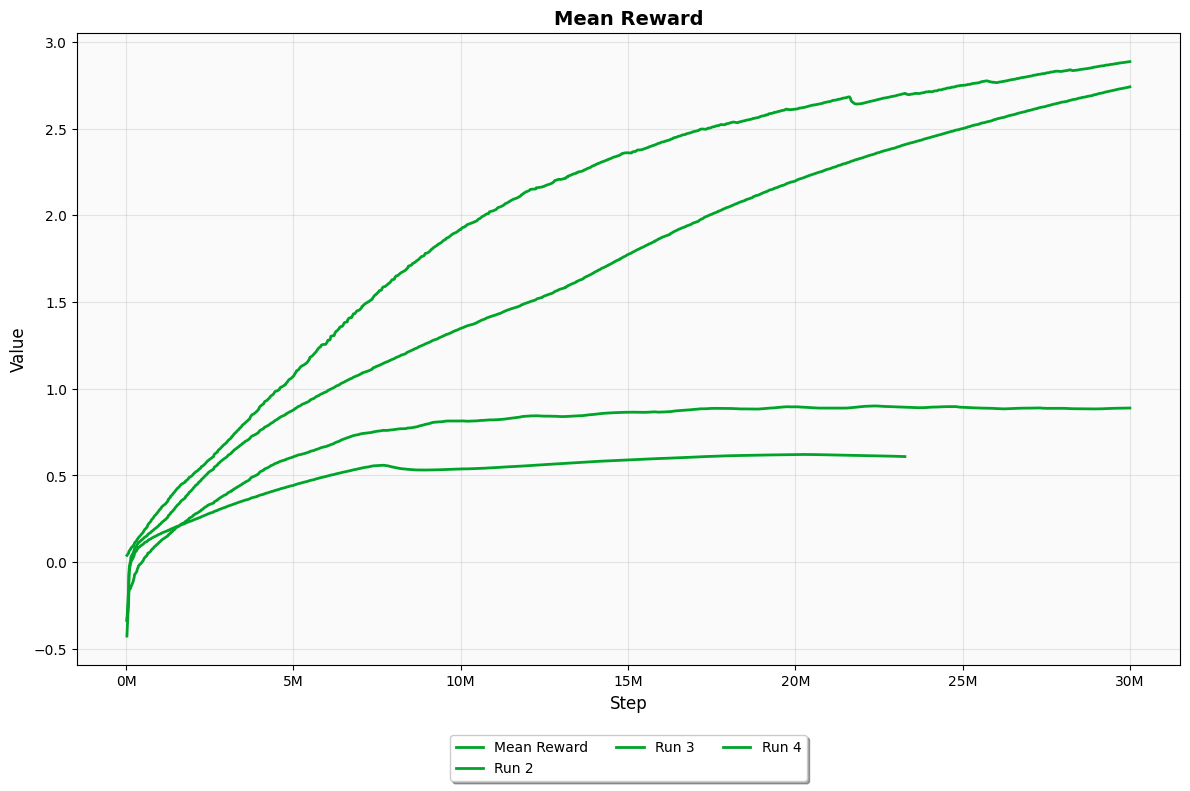

Plot saved to: tensorboard_comparison.png


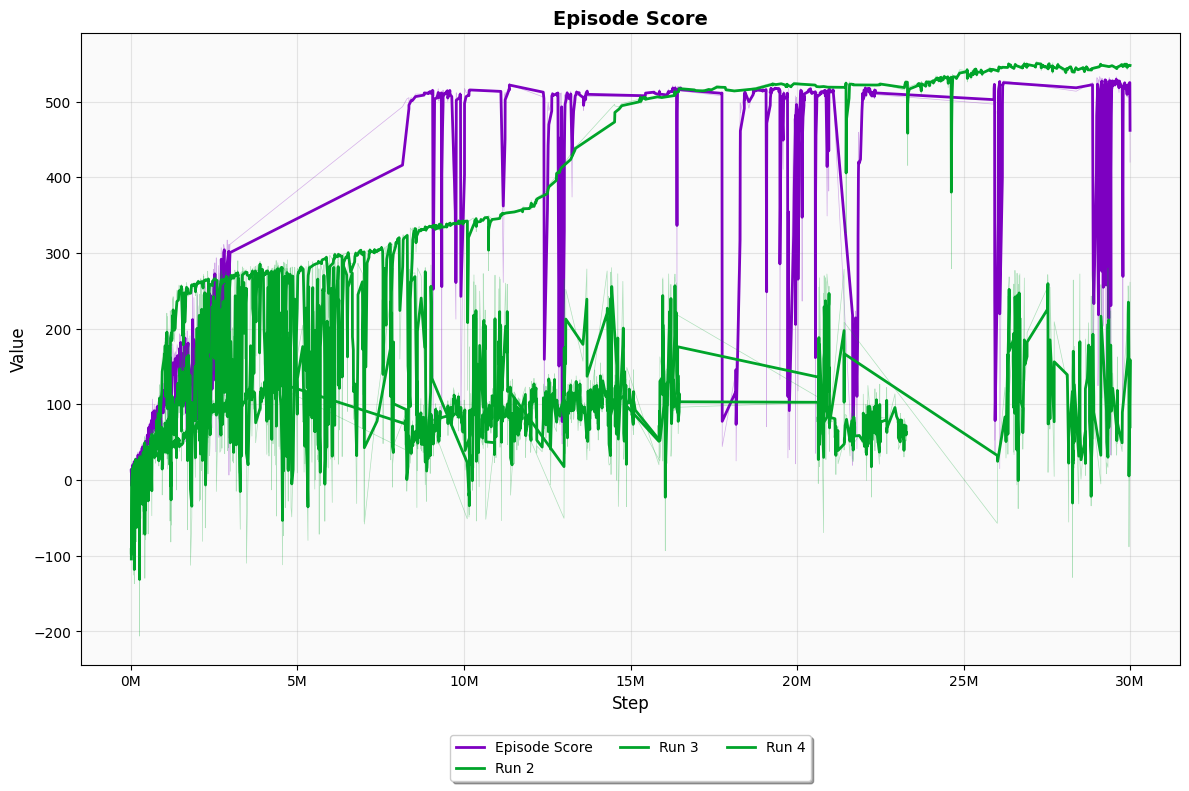

Plot saved to: tensorboard_comparison.png


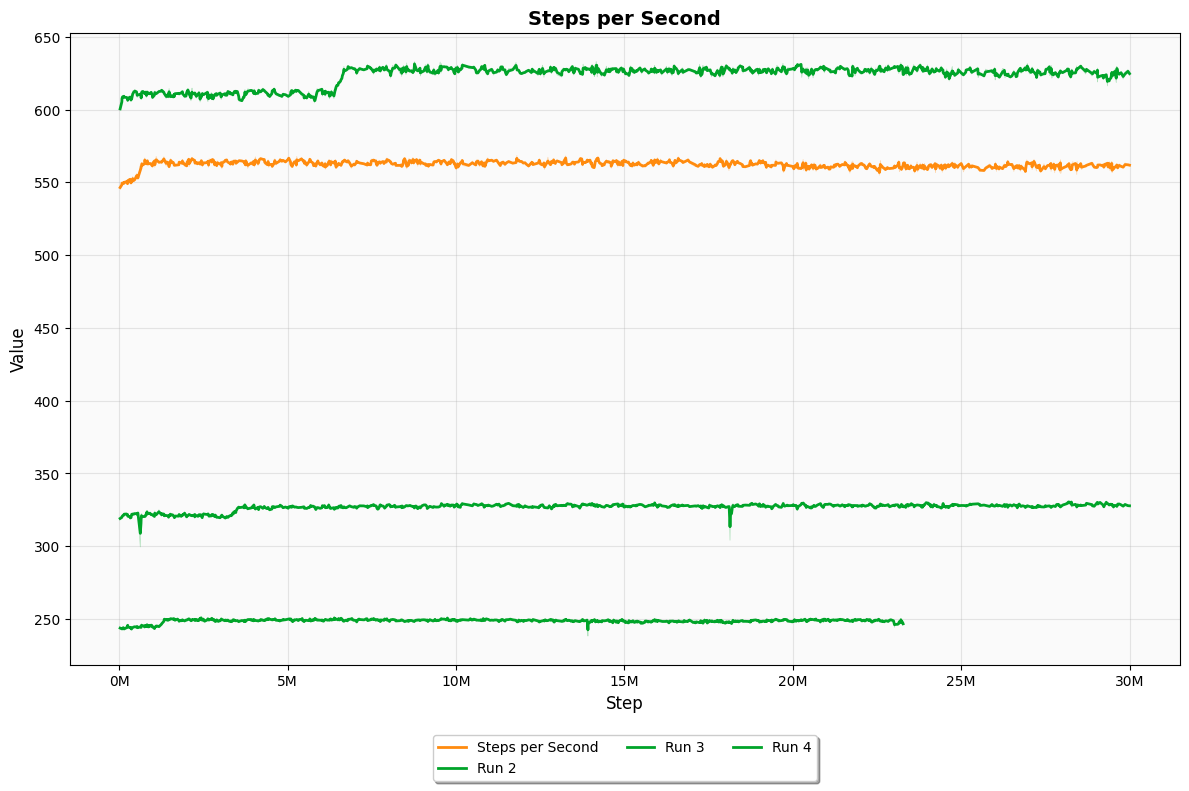

In [ ]:
folders = ["data/Length", "data/MeanReward", "data/Reward", "data/StepsSecond"]
models = ["d4pg", "ddpg", "mpo", "sac"]
titles = ["Episode Length", "Mean Reward", "Episode Score", "Steps per Second"]
for folder, model, title in zip(folders, models, titles):
    csv_files = glob.glob(f"{folder}/*.csv")
    if csv_files:
        quick_plot_multiple(csv_files, models=models, smoothing=0.6, title=title)
    else:
        print(f"No CSV files found in {folder}")